### Import Libraries

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import quantecon as qe
from _model_individual_xxx import FireProblem

### Plotting Preferences

In [3]:
from matplotlib import cm
%matplotlib inline

### Solve for the Value Function

In [5]:
fp = FireProblem(w=40)
v_init = np.array([np.ones((fp.n, 1, fp.t.size+1))*i for i in range(fp.y.size)]).reshape(fp.n,fp.y.size,fp.t.size+1)
v = qe.compute_fixed_point(fp.bellman_operator, v_init, error_tol=1e-3, print_skip=10, max_iter=1000)
#will include time zero when no decision is made

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.775e+00      7.230e+01         
20           9.991e-01      1.432e+02         
30           5.891e-01      2.170e+02         
40           3.520e-01      2.887e+02         
50           2.120e-01      3.569e+02         
60           1.291e-01      4.279e+02         
70           8.179e-02      4.998e+02         
80           5.183e-02      5.692e+02         
90           3.285e-02      6.390e+02         
100          2.082e-02      7.098e+02         
110          1.319e-02      7.810e+02         
120          8.360e-03      8.622e+02         
130          5.298e-03      9.425e+02         
140          3.358e-03      1.028e+03         
150          2.128e-03      1.096e+03         
160          1.348e-03      1.167e+03         


### Solve for the Optimal Policy

In [6]:
optimal_policy = fp.get_greedy(v)
#will include time zero when no decision is made

### Plot the Value Function

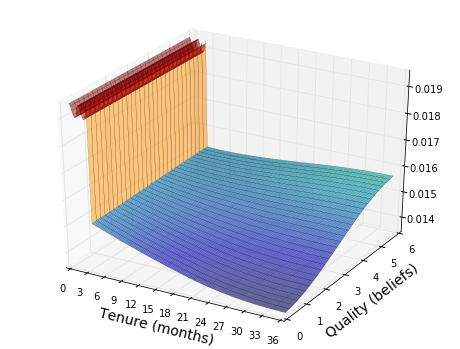

In [15]:
v1 = v[:,:,1:] #remove zero
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v1[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v1[0,:,:]), np.amax(v1[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

### Plot the Optimal Policy

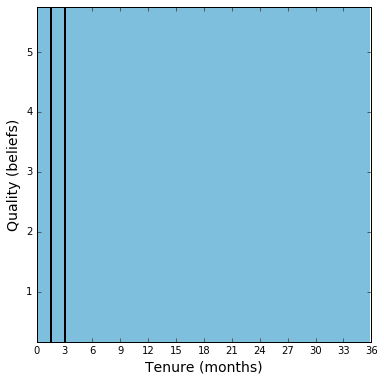

In [16]:
optimal_policy1 = optimal_policy[:,:,1:] #remove zero
fig, ax = plt.subplots(figsize=(6,6))
tg, yg = np.meshgrid(fp.t, fp.y)

lvls=(-0.5, 0.5)
ax.contourf(tg, yg, optimal_policy1[0,:,:], levels=lvls, cmap=cm.winter, alpha=0.5) #for worker 0
ax.contour(tg, yg, optimal_policy1[0,:,:], colors='k', levels=lvls, linewidths=1) #for worker 0

ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

In [17]:
%matplotlib

Using matplotlib backend: Qt4Agg


In [18]:
v1 = v[:,:,1:] #remove zero
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v1[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v1[0,:,:]), np.amax(v1[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

### Checks on VFI Solution

In [19]:
import scipy.integrate as integrate
from scipy import interp
%matplotlib inline
new_v = fp.bellman_operator(v)

In [60]:
#REPEAT UNTIL CONVERGENCE
#...code should use v instead of new_v in the v_cols formula 

#Piecewise linear interpolation functions f(y): value as a function of the belief grid
#...represents the (converging) value assigned V(y',t+1) at each grid column (:,t)
#...loops are necessary due to list comprehension issues with lambda functions
#Columns from 0 to T_max (with T_max duplicate)
v_cols = np.empty(fp.n*fp.y.size*(fp.t.size+1), dtype=object)
it=0
for k in range(fp.n):
    for i in range(fp.y.size):
        for j in range(fp.t.size+1):
            if j != fp.T_max: #from 0 to (T_max-1)
                v_cols[it] = np.array([(lambda z: (lambda x: interp(x, fp.y, z)))(new_v[k,:,(j+1)])])
            else:          #T_max duplicate
                v_cols[it] = np.array([(lambda z: (lambda x: interp(x, fp.y, z)))(new_v[k,:,j])])
            it = it+1

#Keep worker
#...E[V(y',t+1)]: integrate value function with density h_grid (include 95% CI in integral bounds)
E0 = np.array([integrate.fixed_quad(lambda x: v_cols[l][0](x)*fp.h_grid[l](x), i-3*j**0.5, i+3*j**0.5)[0] for l, (i, j) in enumerate(zip(fp.mu_grid.flatten(),fp.sigma_grid.flatten()))]).reshape(fp.n,fp.y.size,fp.t.size+1)
v0 = fp.beta*E0

#Fire worker
#...E[V(y',0)]: integrate value function with density h_0 (include 95% CI in integral bounds)
E1 = np.array([integrate.fixed_quad(lambda x: v_cols[(fp.n*fp.y.size*(fp.t.size+1))*l][0](x)*fp.h_0(x), fp.y_0+fp.w/10-3*fp.sig2_0**0.5, fp.y_0+fp.w/10+3*fp.sig2_0**0.5)[0] for l in range(fp.n) for (i, j) in enumerate(zip(fp.mu_grid.flatten(),fp.sigma_grid.flatten()))]).reshape(fp.n,fp.y.size,fp.t.size+1)
v1 = -fp.costs + fp.beta*E1

In [61]:
policy = (v1>v0).astype(int)
new_v = np.maximum(v0, v1)

In [62]:
policy[0,:,15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0])

In [46]:
new_v = v

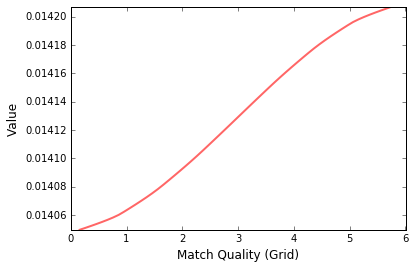

In [21]:
### v_cols: functions that will be integrated with density h_grid or h_0 [varies with each iteration]
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = fp.y
z = v_cols[q*(fp.T_max+1)+r][0](x)
ax.set_ylim(np.amin(v_cols[q*(fp.T_max+1)+r][0](x)), np.amax(v_cols[q*(fp.T_max+1)+r][0](x)))
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.show()

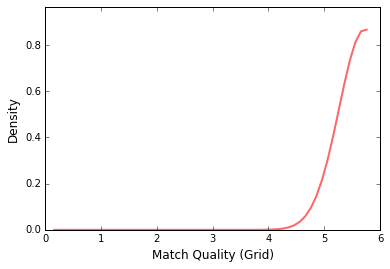

In [34]:
### h_grid: density from beliefs about future quality by grid point when deciding to keep the worker
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = fp.y
z = fp.h_grid[q*(fp.T_max+1)+r](x)
ax.set_ylim(np.amin(fp.h_grid[q*(fp.T_max+1)+r](x)), np.amax(fp.h_grid[q*(fp.T_max+1)+r](x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

In [33]:
#E1
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
np.array([integrate.fixed_quad(lambda x: v_cols[q*(fp.T_max+1)+r][0](x)*fp.h_grid[q*(fp.T_max+1)+r](x), i-3*j**0.5, i+3*j**0.5)[0]])

array([ 0.00443062])

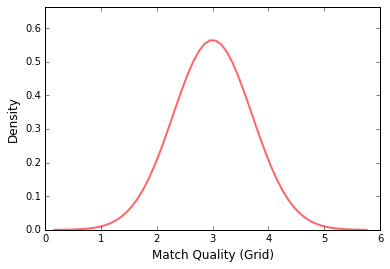

In [35]:
### h_0: density from beliefs about future quality when drawing a new worker
#...this is the prior and does not vary with the grid location
fig, ax = plt.subplots()
x = fp.y
z = fp.h_0(x)
ax.set_ylim(np.amin(fp.h_0(x)), np.amax(fp.h_0(x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

In [32]:
#E0
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
np.array([integrate.fixed_quad(lambda x: v_cols[q*(fp.T_max+1)+r][0](x)*fp.h_0(x), fp.y_0+fp.w/10-3*fp.sig2_0**0.5, fp.y_0+fp.w/10+3*fp.sig2_0**0.5)[0]])

array([ 0.0142097])

In [29]:
(policy[0,:,14], optimal_policy[0,:,14])

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [28]:
(v0[0,:,14], v1[0,:,14])

(array([ 0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872]),
 array([ 0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.01844872,  0.01844872,  0.01844872,  0.01844872,  0.01844872,
         0.0184